# COVID-19 predictions

Pablo Carbonell, pablocarb@gmail.com

Thanks https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html for coding templates!

As in https://covid19.webs.upv.es/, we will use a SIR difference model:

$\begin{eqnarray}
S_{t+1} & = & S_t - \beta S_t \frac{T_t}{n_T} \\
I_{t+1} & = & I_t + \beta S_t \frac{T_t}{n_T} - \gamma I_t \\
R_{t+1} & = & R_t + \gamma I_t
\end{eqnarray}$

where $S$ are the susceptible population, $I$ is the infected and $R$ the recovered. The goal is estimating the paremeters of the model $\hat \beta$ and $\hat \gamma$.

To that end, we will use an optimizer that will minimize the root mean square difference between the predicted infected population $I$ and the actual infected retrieved from official data.

**Note**: We use the data for fitting only from the moment that enough data is available. We consider '3/7/20', the date where at least 500 infected cases were reported as the first date for the training data.

In [15]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import random
import math
import time
from datetime import timedelta, datetime
plt.style.use('seaborn-darkgrid')


In [16]:
#%%
# Retrieve world-wide data
reload = True
if 'reload' not in locals() or reload:
    confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
    deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
    recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
    reload = False
cols = confirmed_df.keys()
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [17]:
# Adapted from https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

START_DATE = {
  'Japan': '1/22/20',
  'Italy': '2/15/20',
  'Republic of Korea': '1/22/20',
  'Iran (Islamic Republic of)': '2/19/20',
  'Spain': '3/7/20',
  'France':'3/15/20'
}

# Total population, N.
country = 'Spain'
ix = confirmed_df['Country/Region'] == country

POPULATION = {
        'Italy' : 60*1000000.0,
        'Spain' : 45*1000000.0,
        'France': 67*1e6
        }
N = POPULATION[country]
# Initial number of infected and recovered individuals, I0 and R0.

incubation_days = 14
incub = int( np.argwhere( confirmed_df.keys() == START_DATE[country] ) ) - incubation_days
I_0 = confirmed_df[ix].iloc[0].loc[START_DATE[country]]
R_0 = recoveries_df[ix].iloc[0].loc[START_DATE[country]]
R_0 = I_0-deaths_df[ix].iloc[0].loc[START_DATE[country]]

I_0 = confirmed_df[ix].iloc[0].loc[START_DATE[country]] - confirmed_df[ix].iloc[0].iloc[incub]
R_0 = I_0-deaths_df[ix].iloc[0].loc[START_DATE[country]] + deaths_df[ix].iloc[0].iloc[incub]

# Everyone else, S0, is susceptible to infection initially.
S_0 = N - I_0 - R_0

class Learner(object):
    def __init__(self, country, loss, confirmed=None):
        self.country = country
        self.loss = loss
        self.confirmed = confirmed

    def load_confirmed(self, country):
      """
      Load confirmed cases downloaded from HDX
      """
      df = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
      country_df = df[df['Country/Region'] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]
  
    def load_confirmed_pablo(self, country, confirmed_df):
        ix = confirmed_df['Country/Region'] == country
        return confirmed_df[ix].iloc[0].loc[START_DATE[country]:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 60
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1))

    def predict_pablo(self, beta, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 60
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def dSIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [S-beta*S*I/N, I+beta*S*I/N - gamma*I, R+gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, dsolve_ivp(dSIR, t_eval=[0, size], y0=[S_0,I_0,R_0])



    def train(self,pablo=True):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        if pablo:      
            data = self.load_confirmed_pablo(self.country, self.confirmed)
        else:
            data = self.load_confirmed(self.country) 
        self.data = data
        optimal = minimize(
            self.loss,
            [0.04*1/S_0, R_0/I_0],
            args=(data),
            method='L-BFGS-B',
            bounds=[(1e-3, 4), (0, 3)],
#            options={'maxiter':1000000,'disp':True}
        )
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = self.predict_pablo(beta, gamma, data)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction[:,0],
            'I': prediction[:,1],
            'R': prediction[:,2]
        }, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        plt.plot(df[['I','Actual']])
        plt.xticks(rotation=90)
        plt.legend(['Infected (predicted)','Infected (actual)'])
        self.df = df
        self.beta = beta
        self.gamma = gamma

def loss(point, data):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    """
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

def dsolve_ivp(fun, t_eval, y0):
        y = y0
        sol = []
        for t in np.arange(t_eval[0], t_eval[1]):
            y = fun(t,y)
            sol.append(y)
        sol = np.array(sol)
        return sol



def loss_pablo(point, data):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    Using a discrete model
    """
    size = len(data)
    beta, gamma = point
    def dSIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [S-beta*S*I/N, I+beta*S*I/N - gamma*I, R+gamma*I]
    sol = dsolve_ivp(dSIR, t_eval=[0, size], y0=[S_0,I_0,R_0])
    rmsd = np.sqrt(np.mean((sol[:,1] - data)**2))
    return rmsd

   



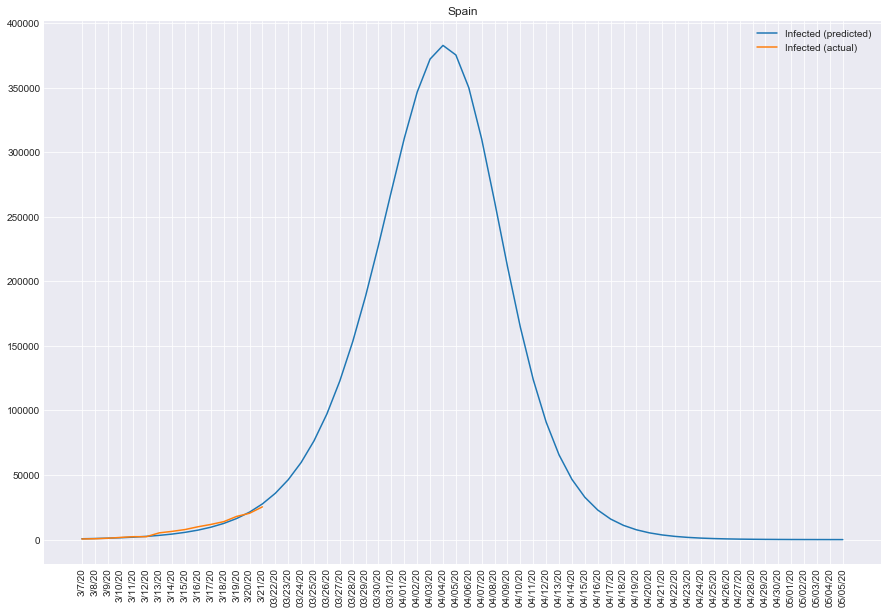

In [18]:
learn = Learner(country, loss_pablo, confirmed_df)
learn.train()
